In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import pickle
import time
import html
import os
import re

import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier


def f1_score_w(y_true, y_pred, **kwargs):
    """
    Score utilisé par Rakuten
    """
    return f1_score(y_true, y_pred, average='weighted')


def read_X(X_file):
    """
    Lecture d'un fichier de données (dataframe) X et petit nettoyage

    """
    df = pd.read_csv(X_file)
    # La première colonne est un doublon:
    #          df["Unnamed: 0"] == df.index 
    df = df.drop("Unnamed: 0", axis=1)
    # Les colonnes designation et description sont à l'origine de type objet
    #          df.info()
    df.designation = df.designation.astype('string')
    df.description = df.description.astype('string')
    return df


def remove_accents(text):
    """
    Supprime les accents du texte <text>
    """
    accents = { 'a': ['à', 'ã', 'á', 'â'],
                'e': ['é', 'è', 'ê', 'ë'],
                'i': ['î', 'ï'],
                'u': ['ù', 'ü', 'û'],
                'o': ['ô', 'ö'] }
    for ch in accents:
        for chacc in accents[ch]:
            text = text.replace(chacc, ch)
    return text


#reclean = re.compile(r"(\<.*?\>|\&\#\d+\;)")
def X_text(X):
    """
    A partir d'un dataframe X retourne une liste de textes (un par échantillon
    du dataframe X)
    """
    lst = []
    for desc, desi in zip(X.description, X.designation):
        descstr = desc if type(desc) == str else ''
        desistr = desi if type(desi) == str else ''
        sep = ' ' if type(desc) == str and type(desi) == str else ''
        s = descstr + sep + desistr
        #s = reclean.sub(' ', s)
        #s = html.unescape(s)
        #s = re.sub(r"(\<)", " \1",s)
        #s = re.sub(r"(\>)", "\1 ",s)
        s = s.lower() + ' ' + re.sub(r"([^A-Z0-9°\+\*\=]+)","",s).lower()
        lst.append(s)
    return lst


spacynlp = None
spacyre = re.compile(r"(<.*?>|&#\d+;|\'|\:|\.|\-|\+)")
french_stop_words = set(stopwords.words('french'))
french_stop_words_no_accent = [remove_accents(x) for x in french_stop_words]
def tokenize_spacy(sentence):
    """
    Tokenizer basé sur spacy
    """
    global spacynlp
    if spacynlp is None:
        spacynlp = spacy.load("fr_core_news_sm")
        spacynlp.disable_pipes ('tagger', 'parser', 'ner')
    s = sentence
    t = [x.lemma_ for x in spacynlp(s)]
    #t = [x.text for x in spacynlp(s) if not x.text in french_stop_words]
    return t


def evaluate_model(name, model, X_trn, X_tst, y_trn, y_tst):
    """
    Entraine un modèle <model> nommé <name> et affiche son score
    """
    start = time.time()
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_tst)
    stop = time.time()
    score = f1_score_w(y_tst, y_pred)
    print(f"{name:<15} weighted-F1-score = {round(score,5)} ({round(stop-start,2)}s)")
    return model


def evaluate_tfclf_step_by_step(name, clf):
    """
    Entraine le model <clf> nommé <name> avec des tailles croissantes d'échantillons
    et affiche une synthèse à la fin
    """
    def display_progress(df, nb):
        r = df.loc[nb]
        print(f"nb={nb} w-f1-score={r.score} ({int(r.vocalen)} mots, {r.time} sec)")
    
    X0 = read_X("X_train_update.csv")
    y0 = pd.read_csv("Y_train_CVw08PX.csv").drop("Unnamed: 0", axis=1)["prdtypecode"]
    test_size = 0.20
    X, y = shuffle(X_text(X0), y0, random_state=51)
    filename = name + ".pkl"
    if os.path.isfile(filename):
        df = pd.read_pickle(filename)
    else:
        df = pd.DataFrame({'nb':[], 'score':[], 'vocalen':[], 'time': []})

    for nb in range(4000, len(X), 8000): ####
        if nb in df.index:
            display_progress(df, nb)
            continue
        X_trn, X_tst, y_trn, y_tst = train_test_split(X[:nb], y[:nb], shuffle=True, random_state=51)
        now = datetime.datetime.now().strftime("%Hh%Mmn")
        print(f"... Evaluation avec {nb} échantillons ({now}) ...")
        start = time.time()
        clf.fit(X_trn, y_trn)
        y_pred = clf.predict(X_tst)
        vocalen = len(clf[0].vocabulary_) ###
        stop = time.time()
        delta = round(stop-start,2)
        score = round(f1_score_w(y_tst, y_pred), 5)
        df.loc[nb] = [nb, score, vocalen, delta]
        display_progress(df, nb)
        df.to_pickle(filename)    

    # Affichage
    filename = name + ".pkl"
    if not os.path.isfile(filename):
        print(f"File {filename} not found!")
        return
    df = pd.read_pickle(filename)
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,1,1)
    ibest = df.score.sort_values().index[-1:]
    bestnb = np.float(df.nb[ibest])
    bestscore = np.float(df.score[ibest])
    plt.plot(df.nb, df.score,c='b', label='weighted F1 score')
    plt.plot(np.array([0, bestnb, bestnb], dtype=object),
             np.array([bestscore, bestscore, 0], dtype=object))
    plt.title(f"Score = {bestscore} pour {int(bestnb)} échantillons")
    plt.xlim(4000, df.nb.max() + 1000)
    plt.ylim(0.5, 1)
    plt.xlabel("Nombre d'échantillons")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

... Evaluation avec 4000 échantillons (00h25mn) ...
nb=4000 w-f1-score=0.69037 (38828 mots, 11.1 sec)
... Evaluation avec 12000 échantillons (00h25mn) ...
nb=12000 w-f1-score=0.77259 (97274 mots, 14.99 sec)
... Evaluation avec 20000 échantillons (00h25mn) ...
nb=20000 w-f1-score=0.80088 (147041 mots, 25.6 sec)
... Evaluation avec 28000 échantillons (00h25mn) ...
nb=28000 w-f1-score=0.80738 (193450 mots, 36.53 sec)
... Evaluation avec 36000 échantillons (00h26mn) ...
nb=36000 w-f1-score=0.82238 (238859 mots, 48.44 sec)
... Evaluation avec 44000 échantillons (00h27mn) ...
nb=44000 w-f1-score=0.83046 (279268 mots, 58.77 sec)
... Evaluation avec 52000 échantillons (00h28mn) ...
nb=52000 w-f1-score=0.83586 (317898 mots, 70.13 sec)
... Evaluation avec 60000 échantillons (00h29mn) ...
nb=60000 w-f1-score=0.84087 (355611 mots, 81.6 sec)
... Evaluation avec 68000 échantillons (00h30mn) ...
nb=68000 w-f1-score=0.84643 (394333 mots, 93.56 sec)
... Evaluation avec 76000 échantillons (00h32mn) ...


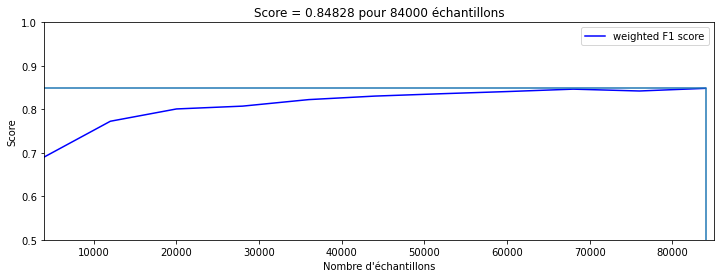

In [2]:
clf_linearsvc = make_pipeline(
    TfidfVectorizer(analyzer='word',
                  tokenizer=tokenize_spacy,
                      #strip_accents='unicode',
                      #stop_words=french_stop_words_no_accent, # peut etre interessant parce que lisse la progression
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
                  ),
    LinearSVC(penalty="l2", dual=True, C=0.8, tol=1e-5, max_iter=4000),
)
evaluate_tfclf_step_by_step("clf_linearsvc_learning", clf_linearsvc)

In [ ]:
# Evaluation sur tous les échantillons
#
X_train = read_X("X_train_update.csv")
y_train = pd.read_csv(
        "Y_train_CVw08PX.csv").drop("Unnamed: 0", axis=1)["prdtypecode"]

# Split train / test
X, y = X_text(X_train), y_train
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=51)

clf_linearsvc.fit(X_trn, y_trn)
y_pred = clf_linearsvc.predict(X_tst)

print(classification_report(y_tst, y_pred))
pd.crosstab(y_tst, y_pred)

In [3]:
from xgboost import XGBClassifier

... Evaluation avec 4000 échantillons (00h40mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:40:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:40:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=4000 w-f1-score=0.6168 (66766 mots, 507.06 sec)
... Evaluation avec 12000 échantillons (00h49mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:49:33] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:34] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=12000 w-f1-score=0.71293 (186013 mots, 2146.74 sec)
... Evaluation avec 20000 échantillons (01h25mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:25:28] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:25:30] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=20000 w-f1-score=0.75283 (294419 mots, 4157.65 sec)
... Evaluation avec 28000 échantillons (02h34mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:34:54] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:34:57] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=28000 w-f1-score=0.78504 (401487 mots, 6358.74 sec)
... Evaluation avec 36000 échantillons (04h20mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:21:03] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:21:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=36000 w-f1-score=0.7926 (508757 mots, 8643.91 sec)
... Evaluation avec 44000 échantillons (06h44mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:45:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:45:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=44000 w-f1-score=0.80836 (604676 mots, 15547.26 sec)
... Evaluation avec 52000 échantillons (11h03mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:35] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:04:40] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=52000 w-f1-score=0.81602 (698396 mots, 12651.64 sec)
... Evaluation avec 60000 échantillons (14h34mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:35:38] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:35:46] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=60000 w-f1-score=0.82212 (790927 mots, 14697.07 sec)
... Evaluation avec 68000 échantillons (18h39mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:41] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:40:48] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=68000 w-f1-score=0.82745 (887189 mots, 17904.44 sec)
... Evaluation avec 76000 échantillons (23h37mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:39:15] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:39:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=76000 w-f1-score=0.83001 (964044 mots, 19710.78 sec)
... Evaluation avec 84000 échantillons (05h06mn) ...


C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:07:53] WARNING: ..\src\learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:08:01] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
nb=84000 w-f1-score=0.83233 (1055812 mots, 22267.43 sec)


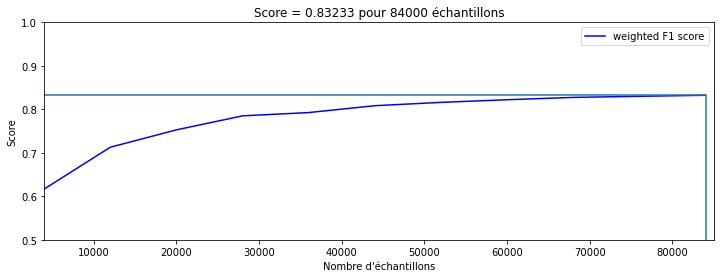

In [4]:
clf_xgb= make_pipeline(
    TfidfVectorizer(analyzer='word',
                  tokenizer=tokenize_spacy,
                      #strip_accents='unicode',
                      #stop_words=french_stop_words_no_accent, # peut etre interessant parce que lisse la progression
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,3),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
                  ),
    XGBClassifier(n_jobs = -1,learning_rate=0.05, n_estimators=3000, min_samples_split=15),
)
evaluate_tfclf_step_by_step("clf_xgboost", clf_xgb)